In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec


In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    tokens = [token for token in tokens if token not in string.punctuation]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [3]:
with open('../data/labelled_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)


In [4]:
for item in data:
    item['text_content'] = preprocess_text(item['text_content'])

In [5]:
with open('../data/updated_json_file.json', 'w') as file:
    json.dump(data, file, indent=2)

In [6]:
with open('../data/updated_json_file.json', 'r') as file:
    data = json.load(file)

In [7]:
df = pd.DataFrame(data)

In [8]:
df

,text_content,sentiment,sentiment_score
0,"[peopl, go, keep, buy, crap, alway, key, word,...",negative,-0.4588
1,"[better, way, convinc, american, support, caus...",positive,0.2028
2,"[context, vivek, immedi, jump, terrorist, atta...",negative,-0.8316
3,"[know, ’, 😂, wonder, go, win, south, carolina,...",positive,0.5859
4,"[tucker, carlson, interview, santiago, abasc, ...",negative,-0.2500
...,...,...,...
405,"[messag, china, clear, era, appeas, halt, flow...",positive,0.9815
406,"[alex, sheppard, perhap, alreadi, know, sent, ...",negative,-0.2732
407,"[ike, amaz, manag, get, fire, anoth, step, lef...",positive,0.0516
408,"[😑, anyon, surpris]",positive,0.2263


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert lists of tokens to space-separated strings
df['text_content_str'] = df['text_content'].apply(lambda x: ' '.join(x))
df


,text_content,sentiment,sentiment_score,text_content_str
0,"[peopl, go, keep, buy, crap, alway, key, word,...",negative,-0.4588,peopl go keep buy crap alway key word “ far ri...
1,"[better, way, convinc, american, support, caus...",positive,0.2028,better way convinc american support caus distu...
2,"[context, vivek, immedi, jump, terrorist, atta...",negative,-0.8316,context vivek immedi jump terrorist attack chr...
3,"[know, ’, 😂, wonder, go, win, south, carolina,...",positive,0.5859,know ’ 😂 wonder go win south carolina primari 😂😂
4,"[tucker, carlson, interview, santiago, abasc, ...",negative,-0.2500,tucker carlson interview santiago abasc vox pa...
...,...,...,...,...
405,"[messag, china, clear, era, appeas, halt, flow...",positive,0.9815,messag china clear era appeas halt flow americ...
406,"[alex, sheppard, perhap, alreadi, know, sent, ...",negative,-0.2732,alex sheppard perhap alreadi know sent jail 19...
407,"[ike, amaz, manag, get, fire, anoth, step, lef...",positive,0.0516,ike amaz manag get fire anoth step left ’ plan...
408,"[😑, anyon, surpris]",positive,0.2263,😑 anyon surpris


In [10]:
# Bag-of-Words (BoW) representation
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(df['text_content_str'])
print("Bag-of-Words features shape:", bow_features.shape)

Bag-of-Words features shape: (410, 866)


In [11]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['text_content_str'])
print("TF-IDF features shape:", tfidf_features.shape)


TF-IDF features shape: (410, 866)


In [12]:
tokenized_text = df['text_content_str'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
word2vec_features = word2vec_model.wv.vectors
print("Word2Vec features shape:", word2vec_features.shape)


Word2Vec features shape: (875, 100)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


In [14]:
X = df['text_content_str']
y = df['sentiment']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [18]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
for label, encoded_label in label_mapping.items():
    print(f"{label} --> {encoded_label}")

Label Mapping:
negative --> 0
neutral --> 1
positive --> 2


In [19]:
models = [SVC(kernel='linear', random_state=42),XGBClassifier(),LogisticRegression(), RandomForestClassifier(),MultinomialNB()]
accuracy=[]
class_reports =[]
for model in models:
    model.fit(X_train_tfidf, y_train_encoded)

    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test_encoded, y_pred)
    class_rep = classification_report(y_test_encoded, y_pred)
    accuracy.append(acc)
    class_reports.append(class_rep)

    print(f'{model.__class__.__name__} Accuracy: {acc:.2f}')
    print(f'{model.__class__.__name__} Classification Report:\n {class_rep}\n \n')


SVC Accuracy: 1.00
SVC Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        35

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

 

XGBClassifier Accuracy: 1.00
XGBClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        35

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

 

LogisticRegression Accuracy: 1.00
LogisticRegression Classification Report:
               precision    recall  f1-sco

In [20]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for SVC
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear']}

# Create SVC model
svc_model = SVC(random_state=42)

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get the best model from the grid search
best_svc_model = grid_search.best_estimator_

In [21]:
best_svc_model

SVC(C=10, gamma=1, kernel='linear', random_state=42)

In [22]:
best_svc_model = grid_search.best_estimator_


In [23]:
y_pred = best_svc_model.predict(X_test_tfidf)

# Evaluate the model
acc = accuracy_score(y_test_encoded, y_pred)
class_rep = classification_report(y_test_encoded, y_pred)

In [24]:
print(class_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        35

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [25]:
import joblib

joblib.dump(svc_model, '../data/svc_model.joblib')


['../data/svc_model.joblib']

In [26]:
preprocessed_new_data = preprocess_text("If he was to reproduce at all it would be asexually in a puddle of toxic bile, regurgitating some pure fucking homunculus of everything that is wrong with the world.")

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
max_words = 10000
max_len = 100

In [30]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [31]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [32]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')


In [33]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [34]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=3, activation='softmax'))

In [35]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
epochs = 5
batch_size = 32

model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model on the test set
y_pred_probs  = model.predict(X_test_padded)
y_pred = y_pred_probs.argmax(axis=-1)
acc = accuracy_score(y_test_encoded, y_pred)
class_rep = classification_report(y_test_encoded, y_pred)

Epoch 1/5


10/10 [==============================] - 4s 93ms/step - loss: 1.0704 - accuracy: 0.5017 - val_loss: 1.0219 - val_accuracy: 0.5152
Epoch 2/5
10/10 [==============================] - 1s 59ms/step - loss: 1.0454 - accuracy: 0.5017 - val_loss: 1.0257 - val_accuracy: 0.5152
Epoch 3/5
10/10 [==============================] - 1s 55ms/step - loss: 1.0367 - accuracy: 0.5017 - val_loss: 1.0303 - val_accuracy: 0.5152
Epoch 4/5
10/10 [==============================] - 1s 59ms/step - loss: 1.0233 - accuracy: 0.5051 - val_loss: 1.0156 - val_accuracy: 0.5455
Epoch 5/5
3/3 [==============================] - 0s 13ms/step


E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [37]:
acc 

0.45121951219512196

In [41]:
# Define hyperparameters to experiment with
units_list = [50, 100, 150]
dropout_list = [0.2, 0.3, 0.4]
recurrent_dropout_list = [0.2, 0.3, 0.4]
optimizer_list = ['adam', 'rmsprop']

In [42]:
best_accuracy = 0
best_params = {}

In [43]:
for units in units_list:
    for dropout in dropout_list:
        for recurrent_dropout in recurrent_dropout_list:
            for optimizer in optimizer_list:
                # Build the model
                model = Sequential()
                model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
                model.add(LSTM(units=units, dropout=dropout, recurrent_dropout=recurrent_dropout))
                model.add(Dense(units=3, activation='softmax'))
                model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Train the model
                model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, validation_split=0.1, verbose=0)

                # Evaluate on the test set
                y_pred_probs = model.predict(X_test_padded)
                y_pred = y_pred_probs.argmax(axis=-1)
                accuracy = accuracy_score(y_test_encoded, y_pred)

                # Check if this set of hyperparameters gives better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'units': units, 'dropout': dropout, 'recurrent_dropout': recurrent_dropout, 'optimizer': optimizer}
                    best_model = model


3/3 [==============================] - 0s 90ms/step


In [44]:
y_pred_probs = best_model.predict(X_test_padded)
y_pred = y_pred_probs.argmax(axis=-1)
acc = accuracy_score(y_test_encoded, y_pred)
class_rep = classification_report(y_test_encoded, y_pred)

3/3 [==============================] - 0s 45ms/step


E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Conestoga\ML programming\Sentiment Analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [45]:
print("Best Parameters:", best_params)
print("Test Accuracy:", acc)
print("Classification Report:\n", class_rep)

Best Parameters: {'units': 50, 'dropout': 0.2, 'recurrent_dropout': 0.2, 'optimizer': 'adam'}
Test Accuracy: 0.45121951219512196
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.07      0.14        27
           1       0.00      0.00      0.00        20
           2       0.44      1.00      0.61        35

    accuracy                           0.45        82
   macro avg       0.48      0.36      0.25        82
weighted avg       0.52      0.45      0.31        82



In [48]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 520353 (1.98 MB)
Trainable params: 520353 (1.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test_encoded, classes=np.unique(y_test_encoded))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

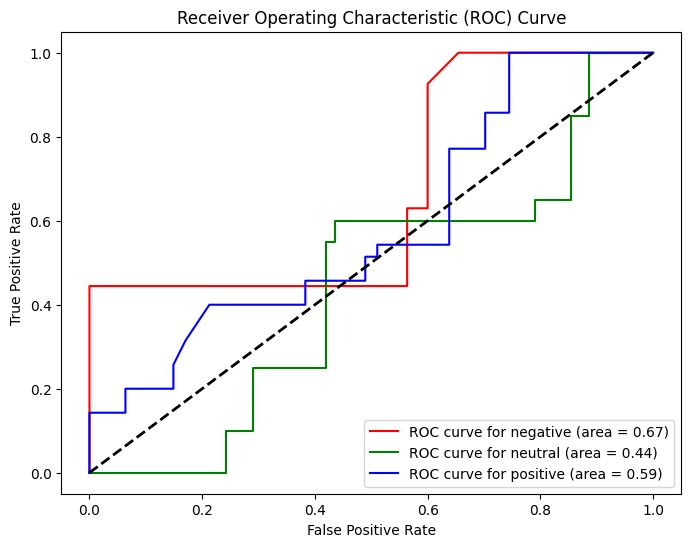

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']  # Adjust the colors based on the number of classes

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve for {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
new_data = ["If he was to reproduce at all it would be asexually in a puddle of toxic bile, regurgitating some pure fucking homunculus of everything that is wrong with the world."]  # Replace this with your actual new text data
new_data_sequences = tokenizer.texts_to_sequences(new_data)
new_data_padded = pad_sequences(new_data_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict sentiment for the new data
new_data_pred_probs = best_model.predict(new_data_padded)
new_data_pred = new_data_pred_probs.argmax(axis=-1)

# Decode predicted labels using the label encoder
predicted_labels = label_encoder.inverse_transform(new_data_pred)

print("Predicted Sentiment:", predicted_labels)

1/1 [==============================] - 0s 23ms/step
Predicted Sentiment: ['positive']


In [ ]:
new_data_tfidf = tfidf_vectorizer.transform(preprocessed_new_data)


In [ ]:
predictions = best_svc_model.predict(new_data_tfidf)


In [ ]:
predictions

In [ ]:
sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
predicted_labels = [sentiment_mapping[prediction] for prediction in predictions]


In [ ]:
predicted_labels

In [ ]:
from collections import Counter

In [ ]:
label_counts = Counter(predicted_labels)


In [ ]:
total_count = len(predicted_labels)
average_sentiment = sum([count * index for index, count in enumerate(label_counts.values())]) / total_count


In [ ]:
print("Label Counts:", label_counts)
print("Average Sentiment:", average_sentiment)